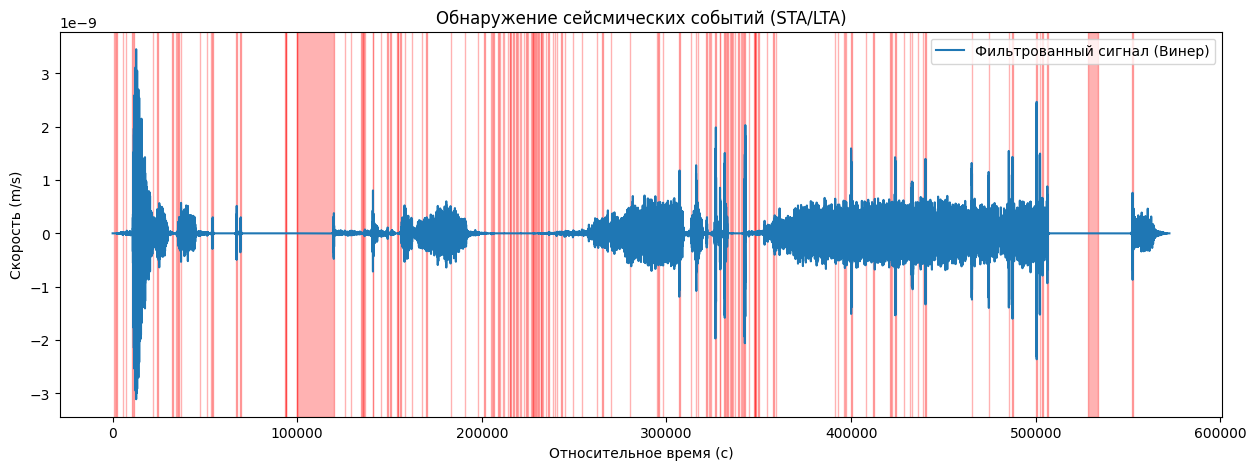

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12521/12521 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - accuracy: 0.8993 - loss: 0.3333 - val_accuracy: 0.8996 - val_loss: 0.3270
Epoch 2/10
12521/12521 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.8995 - loss: 0.3269 - val_accuracy: 0.8996 - val_loss: 0.3260
Epoch 3/10
12521/12521 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.8998 - loss: 0.3260 - val_accuracy: 0.8996 - val_loss: 0.3263
Epoch 4/10
12521/12521 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - accuracy: 0.9000 - loss: 0.3255 - val_accuracy: 0.8996 - val_loss: 0.3261
Epoch 5/10
12521/12521 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - accuracy: 0.8996 - loss: 0.3264 - val_accuracy: 0.8996 - val_loss: 0.3262
Epoch 6/10
12521/12521 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.9000 - loss: 0.3254 - val_accuracy: 0.8996 - val_loss: 0.3261
Epoch 7/10
12521/12521 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.8998 - loss: 0.3258 - val_accuracy: 0.8996 - val_loss: 0.3264
Epoch 8/10
12521/12521 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 

In [21]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from scipy.signal import wiener
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Функция для загрузки данных
file_path = r"D:\space_apps_2024_seismic_detection\data\lunar\test\data\S12_GradeB\xa.s12.00.mhz.1969-12-16HR00_evid00006.csv"
data = pd.read_csv(file_path)

# Использование столбца 'velocity(m/s)' как сигнал
signal = data['velocity(m/s)'].values

# Применение фильтра Винера для удаления шума
filtered_signal_wiener = wiener(signal, mysize=29)

# Параметры STA/LTA для обнаружения событий
nsta = 100  # короткое окно (время)
nlta = 500  # длинное окно (время)
cft = classic_sta_lta(filtered_signal_wiener, nsta, nlta)

# Настройки триггера для обнаружения событий
trig_on = 3.5
trig_off = 1.0
on_off = trigger_onset(cft, trig_on, trig_off)

# Визуализация обнаруженных событий
plt.figure(figsize=(15, 5))
times = np.arange(len(signal))
plt.plot(times, filtered_signal_wiener, label='Фильтрованный сигнал (Винер)')
for onset, offset in on_off:
    plt.axvspan(onset, offset, color='red', alpha=0.3)
plt.title("Обнаружение сейсмических событий (STA/LTA)")
plt.xlabel("Относительное время (с)")
plt.ylabel("Скорость (m/s)")
plt.legend()
plt.show()

# Разбиение данных на окна фиксированной длины
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)

window_size = 50  # Длина окна, можно настроить под задачу
X = create_windows(filtered_signal_wiener, window_size)

# Разметка данных для примера (0 - фон, 1 - событие)
labels = np.zeros(len(X))
for onset, offset in on_off:
    labels[onset:offset] = 1  # Метка события

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, labels[:len(X)], test_size=0.3, random_state=42)

# Изменение формы данных для Conv1D
X_train = np.expand_dims(X_train, axis=2)  # Преобразуем в (samples, timesteps, features)
X_test = np.expand_dims(X_test, axis=2)

# Создание и обучение модели CNN
model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Сигмоид для бинарной классификации
])

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Оценка точности модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Точность модели CNN: {accuracy * 100:.2f}%")
